In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook',font_scale=1.25)
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML,display
import re
import timeit
import gc

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision

In [3]:
!pip install datasets --quiet

In [4]:
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer,DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification

In [5]:
df=pd.read_csv('movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
# checking the number of rows and columns
rows,columns=df.shape[0],df.shape[1]

In [7]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {rows} rows and {columns} columns.</li></ul></h3>"))

In [8]:
# checking for duplicate instances
no_of_duplicates=df.duplicated().sum()

In [9]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {no_of_duplicates} number of duplicate values which need to be dropped.</li></ul></h3>"))

In [10]:
# dropping the duplicate values
df.drop_duplicates(inplace=True)

In [11]:
# checking for NaN values.
no_of_nan_values=df.isna().sum().sum()

In [12]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {no_of_nan_values} NaN values.</li></ul></h3>"))

In [13]:
df['text_word_count']=df['text'].apply(lambda x:len(x.split()))

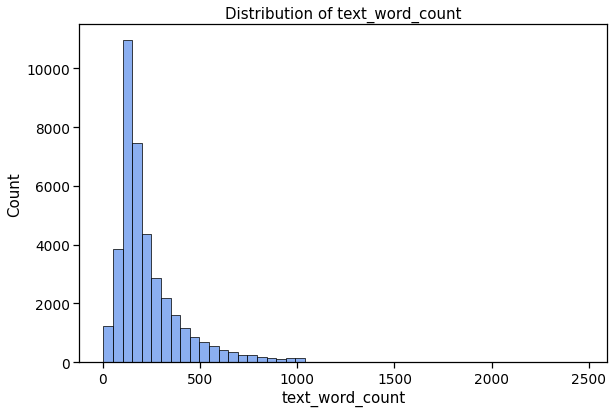

In [14]:
numerical_feature_cols=['text_word_count']
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 100px;font-weight:bold; text-align:left'> Distribution of Various word counts</h3>"))
plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,bins=50,color='#6495ED')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>The distribution of text word count is Right skewed and contains a lot of outliers.</li></ul></h3>"))

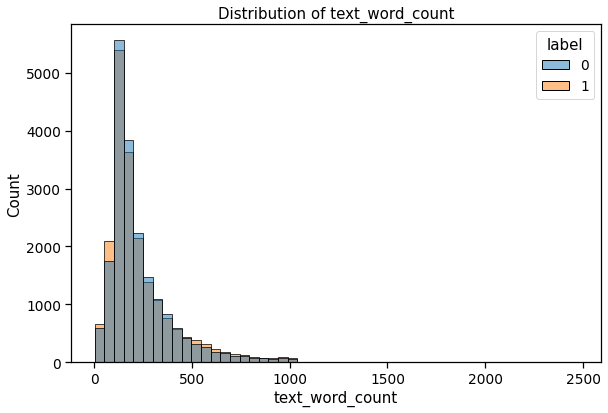

In [15]:
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 60px;font-weight:bold; text-align:left'> Distribution of Various word counts with respect to target</h3>"))

plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,hue='label',bins=50)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>No conclusive trend seen.</li></ul></h3>"))

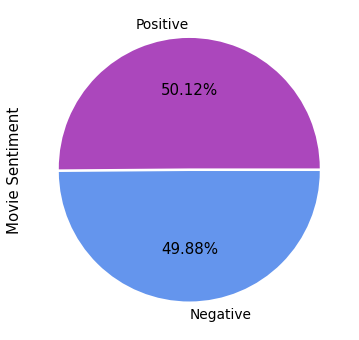

In [16]:
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 70px;font-weight:bold; text-align:left'> Distribution of target</h3>"))
plt.figure(figsize=(10,6))
colors=['#AB47BC','#6495ED']
plt.pie(df['label'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('Movie Sentiment');

In [17]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>The dataset is balanced.</li></ul></h3>"))

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Most common words in Negative ratings</span>

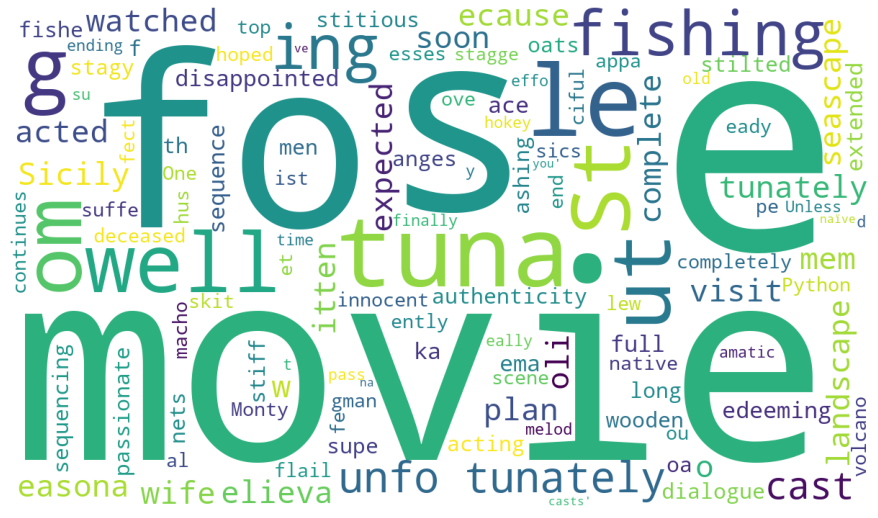

In [18]:
text_list=df.loc[df['label']==0,'text'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Most common words in Positive ratings</span>

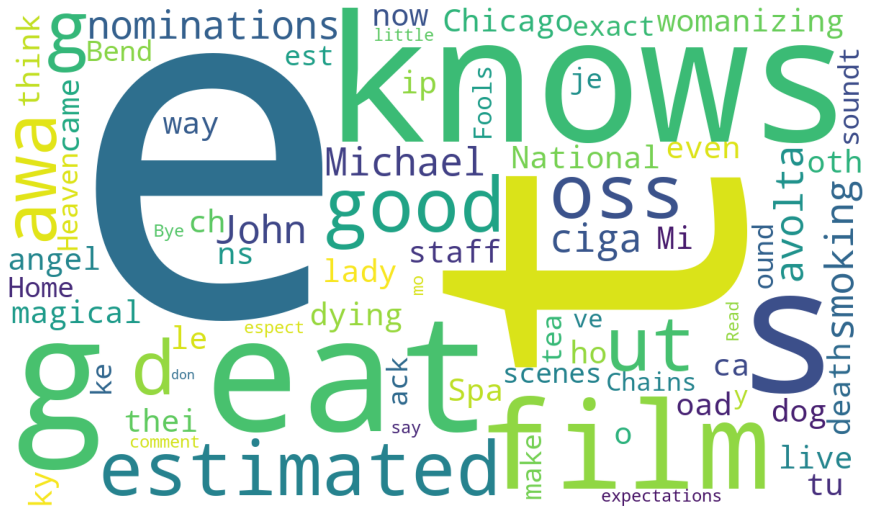

In [19]:
text_list=df.loc[df['label']==1,'text'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Visualizing the Instances</span>


In [20]:
random_index=random.randint(0,df.shape[0]-6)
for row in df[['text','label']][random_index:random_index+5].itertuples():
    _,text,label=row
    class_name="Positive"
    if label==0:
        class_name="Negative"
    display(HTML(f"<h3><b style='color:red'>Text:</b>{text}</h3>"))
    display(HTML(f"<h3><b style='color:red'>Target:</b>{class_name}<br><br><hr></h3>"))


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Splitting the Data into train and test</span>

In [21]:
xtrain,xtest,ytrain,ytest=train_test_split(df['text'].to_numpy(),df['label'].to_numpy(),test_size=0.2,stratify=df['label'].to_numpy())

In [22]:
# check the count of different labels in the train and test set
Counter(ytrain),Counter(ytest)

(Counter({0: 15852, 1: 15926}), Counter({1: 3982, 0: 3963}))

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_0</span>
<h3><li>Using Naive Bayes (MultinomialNB) model to define the baseline accuracy.</li><hr></h3>

In [23]:
# define the model
model_0=Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words='english')),
    ('clf',MultinomialNB())
])

In [24]:
# fit the model
model_0.fit(xtrain,ytrain)

Pipeline(steps=[('tf-idf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB())])

In [25]:
def binary_clf_evaluation(y_true,y_pred,time_taken):
    '''
    accepts true and predicted labels and calculates accuracy,precision,recall and f1_score
    '''
    model_accuracy=accuracy_score(y_true,y_pred)
    
    model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
    
    results={'accuracy':model_accuracy,
             'precision':model_precision,
             'recall':model_recall,
             'f1_score':model_f1_score,
             'time/instance':time_taken
            }
    return results

def store_results(exp_result,exp_name,overall_result=pd.DataFrame()):
    '''
    accepts the dictinary containing the various evaluation metrics for a experiment,the 
    experiment name and overall_result Dataframe and return the overall_result 
    dataframe after concatinating the results of exp_name
    '''
    df=pd.DataFrame(exp_result,index=[exp_name])
    return pd.concat([overall_result,df],axis=0)

def display_results(d):
    '''Takes a dictionary as input and display it using HTML.'''
    display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Model Performance</b>:</h3>"))
    for key,value in d.items():
        if key == "accuracy":
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value*100:.2f}%</h3>"))
        elif key=='time/instance':
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value:.4f} seconds</h3>"))

        else:
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value:.2f}</h3>"))

    

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Results</span>


In [26]:
start_time=timeit.default_timer()
model_0_pred=model_0.predict(xtest)
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_0_results=binary_clf_evaluation(ytest,model_0_pred,time_taken_per_instance)
display_results(model_0_results)
overall_results=store_results(model_0_results,"model_0")

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Converting Data to tensorflow Performant Databatches</span>


In [27]:
training_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

2022-05-09 18:21:33.842971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:21:33.845673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:21:33.847201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:21:33.852898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_1</span>
<h3><li>Using a feed forword Neural Network.</li><hr></h3>



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Tokenization & Vectorization</span>
<h3><li>Here each instance text will be converted into tokens(words) and then it is represented using Numbers.</li></h3>


In [28]:
# define the max vacabolary to tokenize
max_vocab_length=10000
# the words which are not amongst the top 10000 words will be represented using <oov> tag.

In [29]:
# max number of words in a movie review
max([len(x.split()) for x in xtrain])

2470

In [30]:
selected_news_length=round(np.percentile(([len(x.split()) for x in xtrain]),95))
selected_news_length
# this will be able to incoorporate 95 % of the entire instances without trancating the end part.

590

In [31]:
textVectorizer=layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=selected_news_length
);

textVectorizer.adapt(xtrain)

2022-05-09 18:21:43.311344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [32]:
#shape of an instance after textVectorization
textVectorizer(xtrain[0]).shape

TensorShape([590])


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Embedding layer<h3><li>Here each word will be converted into a dence vector so that similar meaning words have approx. same values.</li></h3></span>



In [33]:
embedding=layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=selected_news_length
)
# here each word will be represented using a 128 dim dense vector

In [34]:
# shape of each instance after undergoing embedding layer
embedding(textVectorizer(xtrain[0])).shape

TensorShape([590, 128])

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>


In [35]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.15)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_1=keras.models.Model(inputs,outputs,name="model_1")

2022-05-09 18:21:51.081536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Summary</span>


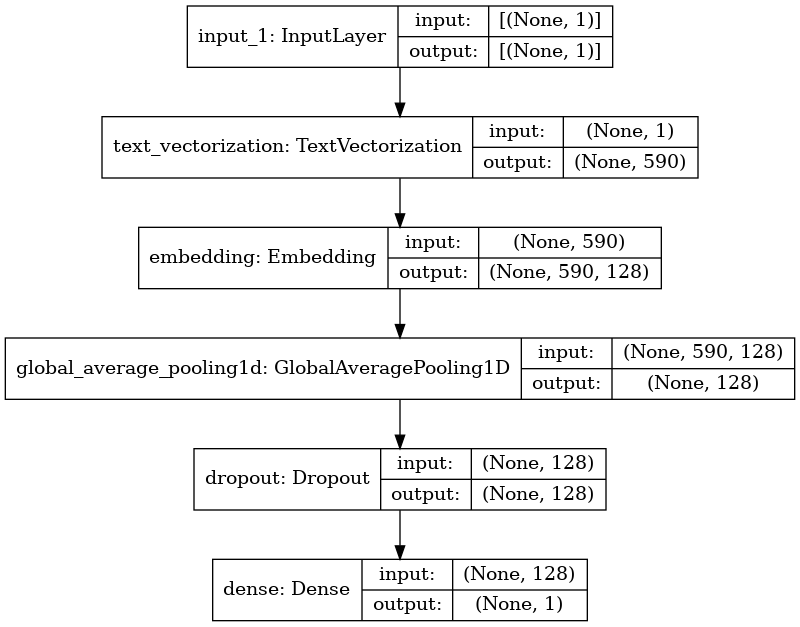

In [36]:
# summary of model_1
keras.utils.plot_model(model_1,show_shapes=True)


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>


In [37]:
model_1.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [38]:
model_1_history=model_1.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
994/994 [==============================] - 14s 11ms/step - loss: 0.5833 - accuracy: 0.7427 - val_loss: 0.4538 - val_accuracy: 0.8232
Epoch 2/5
994/994 [==============================] - 11s 11ms/step - loss: 0.3639 - accuracy: 0.8704 - val_loss: 0.3398 - val_accuracy: 0.8701
Epoch 3/5
994/994 [==============================] - 10s 10ms/step - loss: 0.2855 - accuracy: 0.8946 - val_loss: 0.3034 - val_accuracy: 0.8803
Epoch 4/5
994/994 [==============================] - 11s 11ms/step - loss: 0.2470 - accuracy: 0.9077 - val_loss: 0.2856 - val_accuracy: 0.8863
Epoch 5/5
994/994 [==============================] - 10s 10ms/step - loss: 0.2214 - accuracy: 0.9162 - val_loss: 0.2774 - val_accuracy: 0.8907


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>


In [39]:
start_time=timeit.default_timer()
model_1_pred_prob=model_1.predict(test_dataset)
model_1_pred=tf.squeeze(tf.round(model_1_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_1_results=binary_clf_evaluation(ytest,model_1_pred,time_taken_per_instance)
display_results(model_1_results)

In [40]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    display(HTML('''<p style="background-color:#F1C40F;color:black;font-size:20px;text-align:center;border-radius:30px 60px;font-weight:bold;border:3px solid #F1C40F;">Model Performance Curves</p>"'''))
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

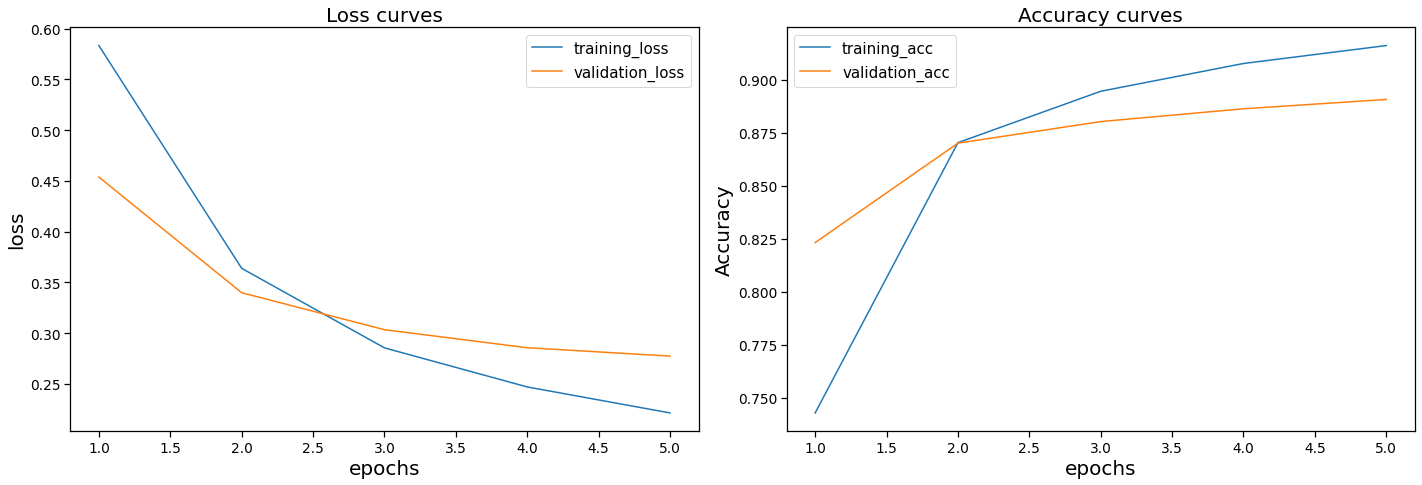

In [41]:
plot_loss_curves(model_1_history)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>


In [42]:
overall_results=store_results(model_1_results,"model_1",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_2</span>
<h3><li>Using Simple RNN.</li><hr></h3>


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>

In [43]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.SimpleRNN(32)(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_2=keras.models.Model(inputs,outputs,name="model_2")

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Summary</span>

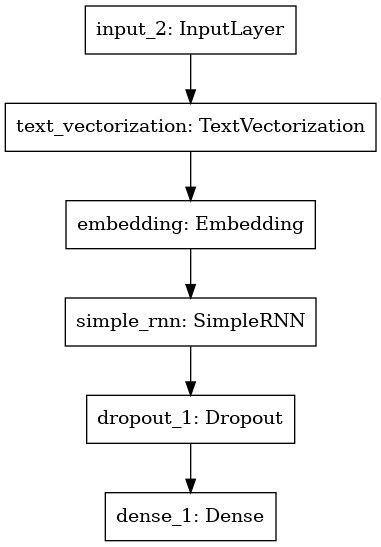

In [44]:
# model_2 summary
keras.utils.plot_model(model_2)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>

In [45]:
model_2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [46]:
model_2_history=model_2.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
994/994 [==============================] - 990s 995ms/step - loss: 0.6889 - accuracy: 0.5292 - val_loss: 0.6939 - val_accuracy: 0.5067
Epoch 2/5
994/994 [==============================] - 1000s 1s/step - loss: 0.7043 - accuracy: 0.4989 - val_loss: 0.6930 - val_accuracy: 0.5070
Epoch 3/5
994/994 [==============================] - 1016s 1s/step - loss: 0.6964 - accuracy: 0.5084 - val_loss: 0.6926 - val_accuracy: 0.5062
Epoch 4/5
994/994 [==============================] - 1029s 1s/step - loss: 0.6938 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5043
Epoch 5/5
994/994 [==============================] - 1004s 1s/step - loss: 0.6922 - accuracy: 0.5086 - val_loss: 0.6938 - val_accuracy: 0.4970


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>


In [47]:
start_time=timeit.default_timer()
model_2_pred_prob=model_2.predict(test_dataset)
model_2_pred=tf.squeeze(tf.round(model_2_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_2_results=binary_clf_evaluation(ytest,model_2_pred,time_taken_per_instance)
display_results(model_2_results)

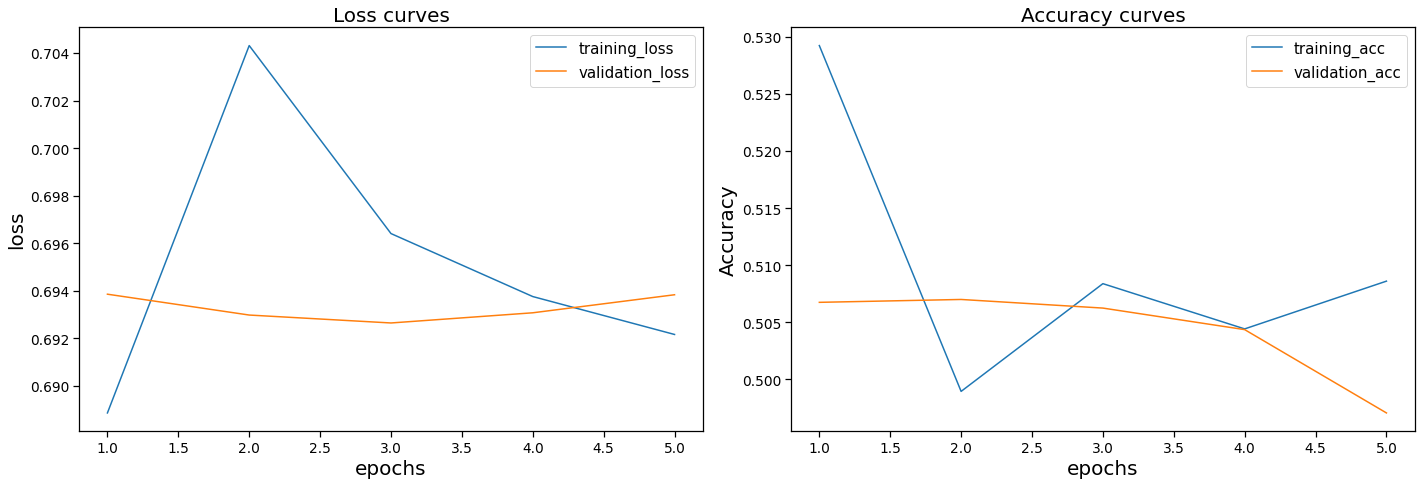

In [48]:
plot_loss_curves(model_2_history)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [49]:
overall_results=store_results(model_2_results,"model_2",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093




<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_3</span>
<h3><li>Using LSTM (single layer).</li><hr></h3>

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>

In [50]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.LSTM(64)(x)
x=layers.Dropout(0.1)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_3=keras.models.Model(inputs,outputs,name="model_3")

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Summary</span>

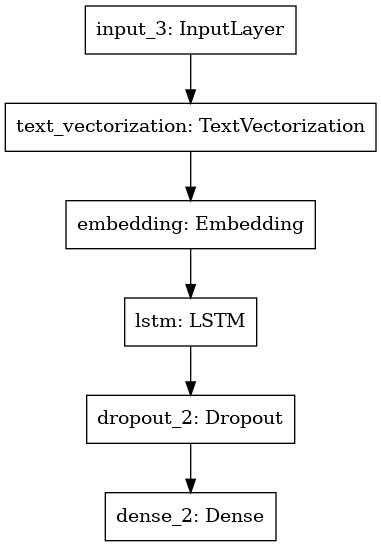

In [51]:
keras.utils.plot_model(model_3)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>

In [52]:
model_3.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>

In [53]:
model_3_history=model_3.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5


2022-05-09 19:50:18.254851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


994/994 [==============================] - 53s 50ms/step - loss: 0.6534 - accuracy: 0.5732 - val_loss: 0.5367 - val_accuracy: 0.7729
Epoch 2/5
994/994 [==============================] - 52s 53ms/step - loss: 0.5600 - accuracy: 0.7196 - val_loss: 0.6794 - val_accuracy: 0.5356
Epoch 3/5
994/994 [==============================] - 52s 52ms/step - loss: 0.5735 - accuracy: 0.7120 - val_loss: 0.5512 - val_accuracy: 0.7592
Epoch 4/5
994/994 [==============================] - 54s 54ms/step - loss: 0.5825 - accuracy: 0.6840 - val_loss: 0.5623 - val_accuracy: 0.7663
Epoch 5/5
994/994 [==============================] - 53s 54ms/step - loss: 0.4982 - accuracy: 0.7975 - val_loss: 0.5664 - val_accuracy: 0.7538



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>

In [54]:
start_time=timeit.default_timer()
model_3_pred_prob=model_3.predict(test_dataset)
model_3_pred=tf.squeeze(tf.round(model_3_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_3_results=binary_clf_evaluation(ytest,model_3_pred,time_taken_per_instance)
display_results(model_3_results)

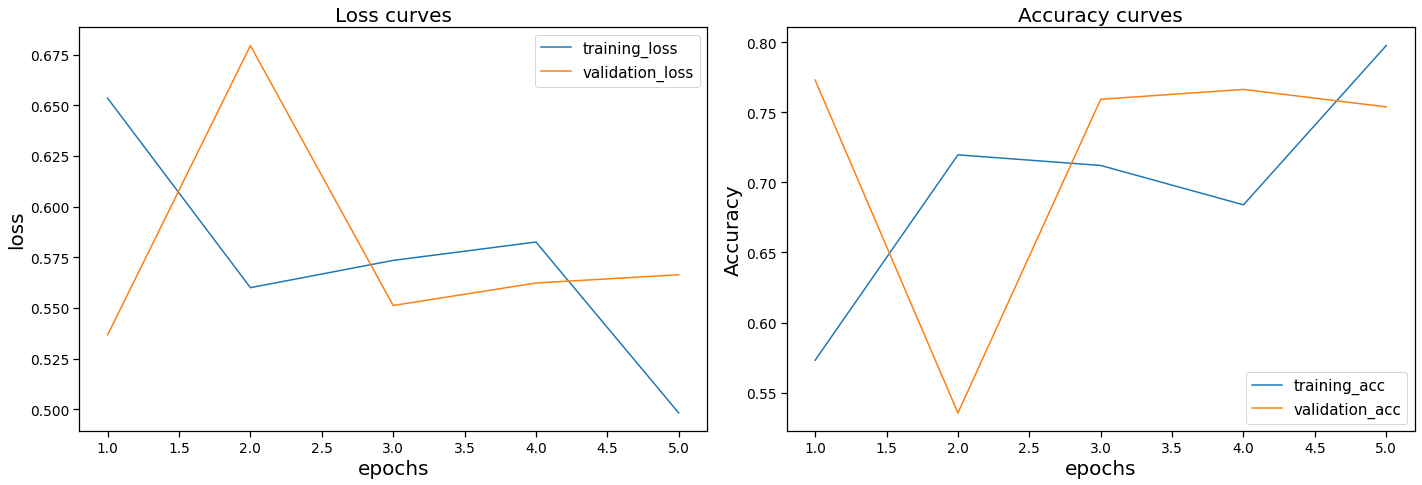

In [55]:
plot_loss_curves(model_3_history)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [56]:
overall_results=store_results(model_3_results,"model_3",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093
model_3,0.753807,0.754090,0.753807,0.753753,0.000639




<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_4</span>
<h3><li>Using LSTMs (stacked).</li><hr></h3>


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>

In [57]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.Dropout(0.2)(x)
x=layers.LSTM(32)(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_4=keras.models.Model(inputs,outputs,name="model_4")

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Summary</span>


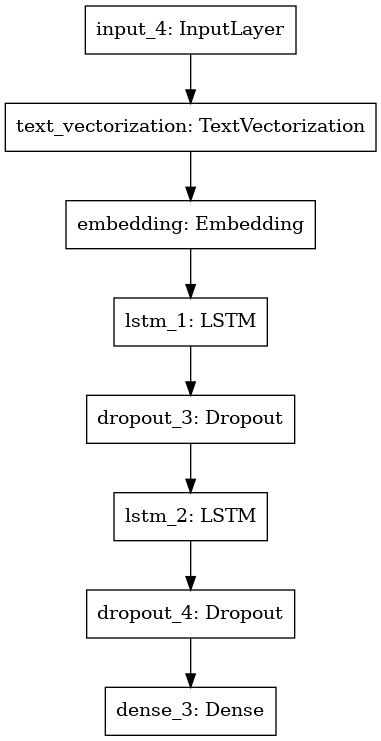

In [58]:
keras.utils.plot_model(model_4)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>



In [59]:
model_4.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [60]:
model_4_history=model_4.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
994/994 [==============================] - 99s 95ms/step - loss: 0.6786 - accuracy: 0.5296 - val_loss: 0.6888 - val_accuracy: 0.5166
Epoch 2/5
994/994 [==============================] - 98s 99ms/step - loss: 0.6503 - accuracy: 0.5763 - val_loss: 0.6995 - val_accuracy: 0.5106
Epoch 3/5
994/994 [==============================] - 95s 96ms/step - loss: 0.6482 - accuracy: 0.5933 - val_loss: 0.6050 - val_accuracy: 0.7018
Epoch 4/5
994/994 [==============================] - 95s 96ms/step - loss: 0.6028 - accuracy: 0.6805 - val_loss: 0.5882 - val_accuracy: 0.7255
Epoch 5/5
994/994 [==============================] - 100s 101ms/step - loss: 0.5525 - accuracy: 0.7436 - val_loss: 0.3997 - val_accuracy: 0.8365


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>


In [61]:
start_time=timeit.default_timer()
model_4_pred_prob=model_4.predict(test_dataset)
model_4_pred=tf.squeeze(tf.round(model_4_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_4_results=binary_clf_evaluation(ytest,model_4_pred,time_taken_per_instance)
display_results(model_4_results)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [62]:
overall_results=store_results(model_4_results,"model_4",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093
model_3,0.753807,0.754090,0.753807,0.753753,0.000639
model_4,0.836501,0.845098,0.836501,0.835438,0.001191



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_5</span>
<h3><li>Using Tensorflow pretrained model Universal Sentence Encoder(USE).</li><hr></h3>

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>

In [63]:
pretained_embedding=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False,input_shape=[],dtype=tf.string,name="USE")
model_5=keras.Sequential([
    pretained_embedding,
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid',dtype=tf.float32)
])

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Summary</span>


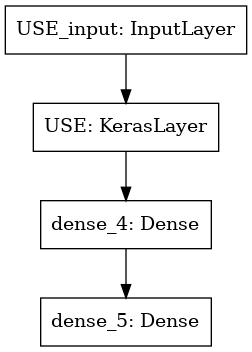

In [64]:
keras.utils.plot_model(model_5)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>


In [65]:
model_5.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [66]:
model_5_history=model_4.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
994/994 [==============================] - 95s 96ms/step - loss: 0.2789 - accuracy: 0.8946 - val_loss: 0.3021 - val_accuracy: 0.8837
Epoch 2/5
994/994 [==============================] - 95s 96ms/step - loss: 0.1957 - accuracy: 0.9316 - val_loss: 0.3099 - val_accuracy: 0.8965
Epoch 3/5
994/994 [==============================] - 96s 97ms/step - loss: 0.1521 - accuracy: 0.9488 - val_loss: 0.3487 - val_accuracy: 0.8953
Epoch 4/5
994/994 [==============================] - 104s 105ms/step - loss: 0.1225 - accuracy: 0.9629 - val_loss: 0.3511 - val_accuracy: 0.8958
Epoch 5/5
994/994 [==============================] - 97s 98ms/step - loss: 0.1129 - accuracy: 0.9659 - val_loss: 0.3688 - val_accuracy: 0.8905


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>


In [67]:
start_time=timeit.default_timer()
model_5_pred_prob=model_5.predict(test_dataset)
model_5_pred=tf.squeeze(tf.round(model_5_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_5_results=binary_clf_evaluation(ytest,model_5_pred,time_taken_per_instance)
display_results(model_5_results)

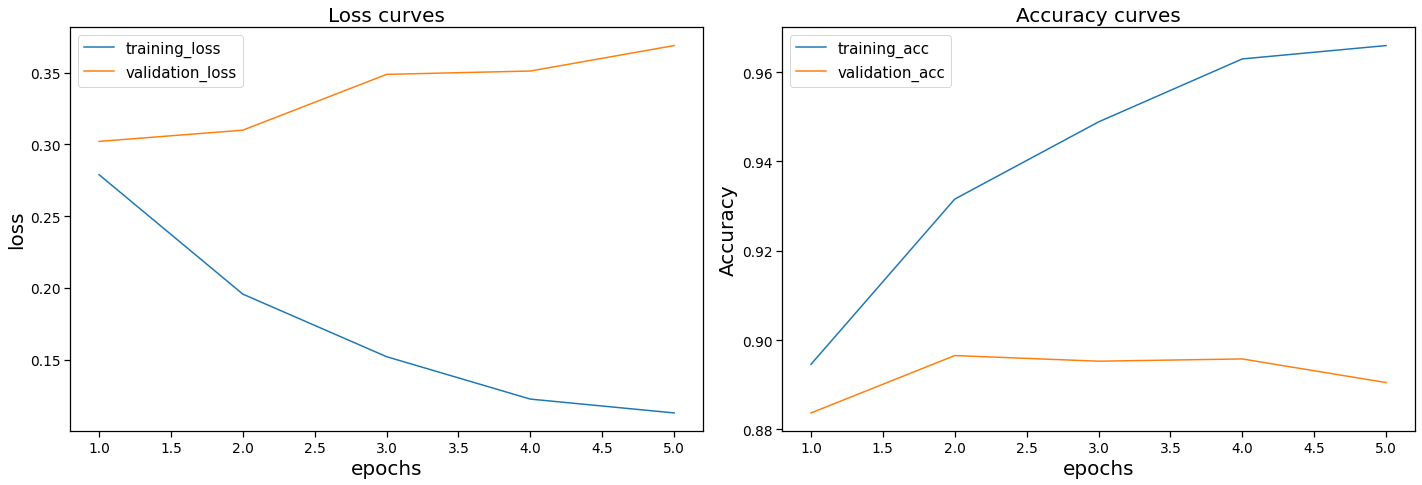

In [68]:
plot_loss_curves(model_5_history)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [69]:
overall_results=store_results(model_5_results,"model_5",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093
model_3,0.753807,0.754090,0.753807,0.753753,0.000639
model_4,0.836501,0.845098,0.836501,0.835438,0.001191
model_5,0.477281,0.466603,0.477281,0.428799,0.001475



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">Fine tunning model_5</span>

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Unfreezing the layers</span>

In [70]:
pretained_embedding.trainable=True

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Recompile the model</span>

In [71]:
model_5.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Defining Callbacks</span>

In [72]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,verbose=2)
reduce_lr_cb=keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,min_delta=0.001,min_lr=1e-7,verbose=2)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [73]:
model_5_history_fn=model_5.fit(
    training_dataset,
    epochs=25,
    steps_per_epoch=len(training_dataset),
    initial_epoch=4,
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    callbacks=[early_stopping_cb,reduce_lr_cb]
)

Epoch 5/25
994/994 [==============================] - 161s 151ms/step - loss: 0.3922 - accuracy: 0.8386 - val_loss: 0.3040 - val_accuracy: 0.8709
Epoch 6/25
994/994 [==============================] - 149s 150ms/step - loss: 0.1703 - accuracy: 0.9362 - val_loss: 0.2928 - val_accuracy: 0.8826
Epoch 7/25
994/994 [==============================] - 150s 151ms/step - loss: 0.0594 - accuracy: 0.9827 - val_loss: 0.3731 - val_accuracy: 0.8750
Epoch 8/25
994/994 [==============================] - 149s 150ms/step - loss: 0.0165 - accuracy: 0.9968 - val_loss: 0.3604 - val_accuracy: 0.8938

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 9/25
994/994 [==============================] - 150s 151ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.3687 - val_accuracy: 0.8935
Epoch 10/25
994/994 [==============================] - 150s 151ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.3830 - val_accuracy: 0.8939
Restoring model weights from the end of t

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>


In [74]:
start_time=timeit.default_timer()
model_5_pred_prob_fn=model_5.predict(test_dataset)
model_5_pred_fn=tf.squeeze(tf.round(model_5_pred_prob_fn))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_5_results_fn=binary_clf_evaluation(ytest,model_5_pred_fn,time_taken_per_instance)
display_results(model_5_results_fn)

In [75]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>Fine-tunning the model was beneficial in further improving the performance of the model.</li></ul></h3>"))

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [76]:
overall_results=store_results(model_5_results_fn,"model_5_fn",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093
model_3,0.753807,0.754090,0.753807,0.753753,0.000639
model_4,0.836501,0.845098,0.836501,0.835438,0.001191
model_5,0.477281,0.466603,0.477281,0.428799,0.001475
model_5_fn,0.882568,0.886573,0.882568,0.882279,0.001590


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 210px">model_6</span>
<h3><li>Using Transformers,fine tunning pretrained model from HuggingFace Model Hub.</li><hr></h3>

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Load Data</span>

In [77]:
data=load_dataset('csv',data_files='../input/imdb-movie-ratings-sentiment-analysis/movie.csv')
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-68c3421472e5cc28/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 40000
    })
})

In [78]:
# Visualizing the train data
data['train'][0]

{'text': 'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 'label': 0}

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Converting to lowercase</span>

In [79]:
# converting to lowercase
def lowercase_text(example):
    return{'text':example['text'].lower()}
data=data.map(lowercase_text)

  0%|          | 0/40000 [00:00<?, ?ex/s]

In [80]:
# After conversion
data['train'][0]

{'text': 'i grew up (b. 1965) watching and loving the thunderbirds. all my mates at school watched. we played "thunderbirds" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the only high point was the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created. jonatha frakes should hand in his directors chair, his version was completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp. sapiens was a huge error of judgment.',
 'label': 0}

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Tokenization</span>

In [81]:
checkpoint='bert-base-uncased'
# checkpoint='roberta-large-mnli'

tokenizer=AutoTokenizer.from_pretrained(checkpoint)

#defining the tokenization function
def tokenize_function(example):
    return tokenizer(example['text'],truncation=True)

tokenized_dataset=data.map(tokenize_function,batched=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

In [82]:
#policy to be used while batching
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Split Data into train and test</span>

In [83]:
tokenized_splitted_dataset=tokenized_dataset['train'].train_test_split(test_size=0.2)
test_set_lenght=len(tokenized_splitted_dataset['test']['label'])
tokenized_splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
})

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Converting Data into Data Batches</span>

In [84]:
tf_train_dataset = tokenized_splitted_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
).prefetch(tf.data.AUTOTUNE)

tf_validation_dataset = tokenized_splitted_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
).prefetch(tf.data.AUTOTUNE)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Build the model</span>


In [85]:
model_6 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Defining Polynomial Decay learning rate schedule</span>


In [86]:
epochs=3
mini_batches=int(0.2*len(tf_train_dataset))
num_steps=epochs*mini_batches
learning_rate_schedule=PolynomialDecay(
    initial_learning_rate=5e-5,
    decay_steps=num_steps,
    end_learning_rate=0.0,   
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Compile the model</span>


In [87]:
model_6.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=['accuracy']
)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Fit the model</span>


In [88]:
model_6_history=model_6.fit(
    tf_train_dataset,
    steps_per_epoch=int(0.2*len(tf_train_dataset)),
    epochs=epochs,
    validation_data=tf_validation_dataset
)

Epoch 1/3
800/800 [==============================] - 633s 756ms/step - loss: 0.2957 - accuracy: 0.8764 - val_loss: 0.2226 - val_accuracy: 0.9101
Epoch 2/3
800/800 [==============================] - 603s 754ms/step - loss: 0.2255 - accuracy: 0.9119 - val_loss: 0.1942 - val_accuracy: 0.9222
Epoch 3/3
800/800 [==============================] - 603s 754ms/step - loss: 0.1896 - accuracy: 0.9259 - val_loss: 0.1858 - val_accuracy: 0.9281


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model Result</span>

In [89]:
start_time=timeit.default_timer()
model_6_pred_logits=model_6.predict(tf_validation_dataset)
model_6_pred=tf.round(tf.nn.sigmoid(model_6_pred_logits['logits']))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/test_set_lenght
model_6_results=binary_clf_evaluation(tokenized_splitted_dataset['test']['label'],model_6_pred,time_taken_per_instance)
display_results(model_6_results)

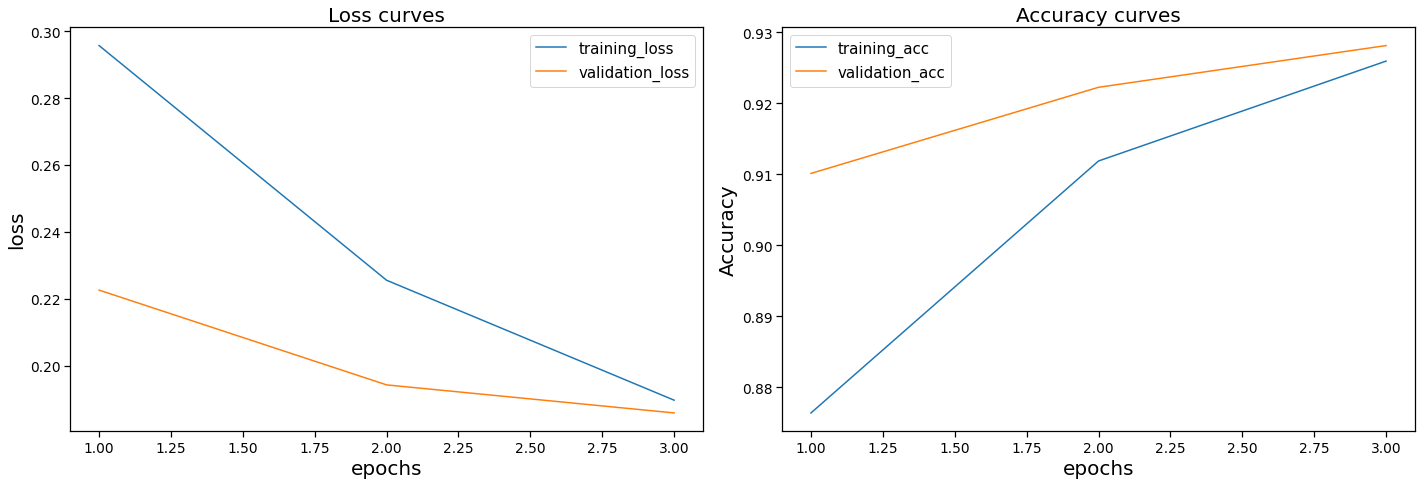

In [91]:
plot_loss_curves(model_6_history)

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Summary</span>

In [92]:
overall_results=store_results(model_6_results,"model_6",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.863184,0.863555,0.863184,0.863156,0.000227
model_1,0.890749,0.891775,0.890749,0.890685,0.000164
model_2,0.497042,0.497025,0.497042,0.497009,0.003093
model_3,0.753807,0.754090,0.753807,0.753753,0.000639
model_4,0.836501,0.845098,0.836501,0.835438,0.001191
model_5,0.477281,0.466603,0.477281,0.428799,0.001475
model_5_fn,0.882568,0.886573,0.882568,0.882279,0.001590
model_6,0.926875,0.927327,0.926875,0.926852,0.023274


<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Best model as per f1_score</span>

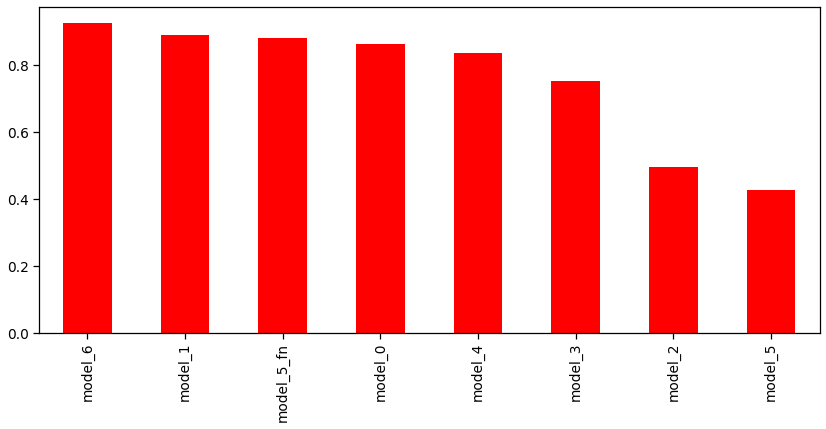

In [93]:
overall_results.sort_values(by='f1_score',ascending=False)['f1_score'].plot(kind='bar',figsize=(14,6),color='red');

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">Best model as per time taken/prediction</span>

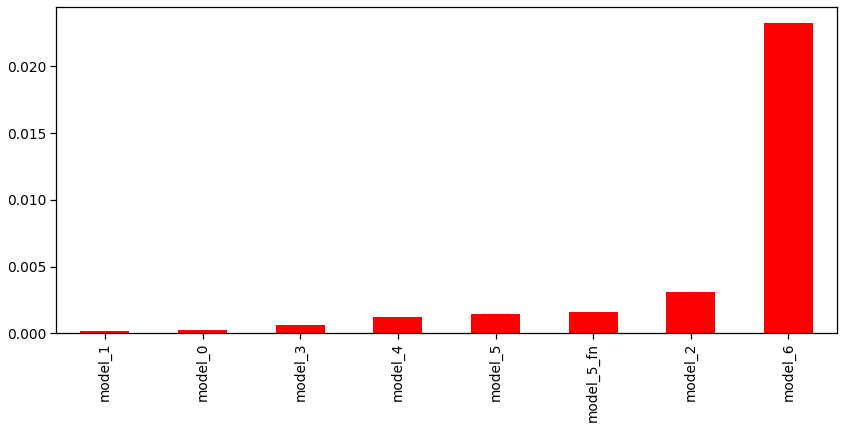

In [94]:
overall_results.sort_values(by='time/instance',ascending=True)['time/instance'].plot(kind='bar',figsize=(14,6),color='red');

<span style="background-color:#F1C40F;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #F1C40F;padding:0px 20px">model f1_score vs time taken/prediction</span>

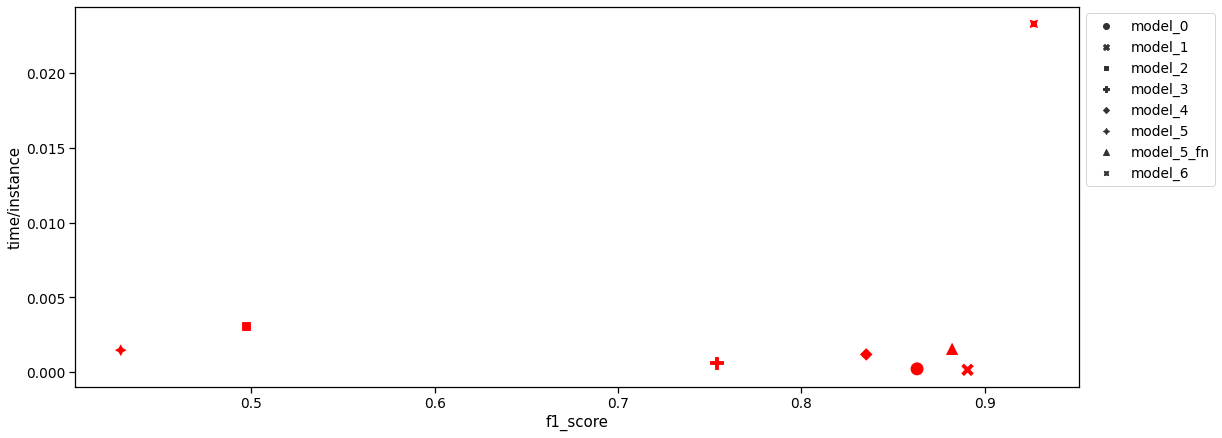

In [95]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=overall_results,x='f1_score',y='time/instance',s=200,color='red',style=overall_results.index);
plt.legend(bbox_to_anchor=(1.0,1.0));

<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>We will not find the model which has best of two worlds that is higher f1_score and lower time/instance.</li><br>
    <li> Depending upon our need we need to comprise on one front.</li><br>
    <li> If our need is being accurate then we will have compromise on time taken per prediction and if our need is speed of prediction taken accuracy will be compromised.</li><br>
    <li> In my opiniion model_1 is consistant on both fronts and will work well in most systems.</li>
 </ul></h3>